This notebook looks at the distribution of ranks for each method and mutation type in order to make an informed decision on which methods to use for each case. The pLDDT, differential pLDDT, BLOSUM, DeepDDG and DeMaSk procedures were translated into R from the sources below.

pLDDT, BLOSUM, DeepDDG and DeMaSk procedures are from:
* https://www.kaggle.com/code/dschettler8845/novo-esp-eli5-performant-approaches-lb-0-425 

with additional references:
* https://www.kaggle.com/code/kvigly55/plldt-and-ddg
* https://www.kaggle.com/code/lucasmorin/nesp-changes-eda-and-baseline
* https://www.kaggle.com/code/hengck23/lb0-335-deepdgg-server-benchmark

Differential pLDDT procedure is from:
* https://www.kaggle.com/code/cdeotte/difference-features-lb-0-600

with mutation PDB files from:
* https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361816
* https://www.kaggle.com/datasets/roberthatch/nesp-kvigly-test-mutation-pdbs

RMSD and SASA from MD simulation procedure:
* https://www.kaggle.com/code/oxzplvifi/rmsd-from-molecular-dynamics

with the following two MD simulation outputs used:
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md for SASA measurement
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md2 for RMSD measurement

The output files of Rosetta and Thermonet were loaded directly since I am not sure yet if they can be implemented in R:
* https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores for Rosetta
* https://www.kaggle.com/code/vslaykovsky/nesp-thermonet-v2 for Thermonet

# Testing set preprocessing

Record the location in the sequence of each mutation or deletion for each row as in https://www.kaggle.com/code/oxzplvifi/novozymes-in-r-blosum-deepddg-demask

In [1]:
import os

from tqdm.auto import tqdm
from scipy.stats import rankdata

import numpy as np
import pandas as pd

import Levenshtein

import matplotlib.pyplot as plt
import seaborn as sns

two_colors = sns.xkcd_palette(['red', 'bright blue'])

In [2]:
def rank_nrom(name):
    s = test_df['{}_rank'.format(name)]
    return s/s.max()

In [3]:
# Plot rank distributions
def plot_rank_dist(name, ax, show_del=False):

    sns.kdeplot(
        data=test_df.query('type=="SUB"'),
        x='{}_rank'.format(name),
        bw_adjust=0.3,
        lw=3,
        label='SUB',
        ax=ax,
        color='k'
    )

    ax.vlines(
        test_df.query('type=="DEL"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='DEL',
        color=two_colors[0]
    )

    ax.vlines(
        test_df.query('type=="WT"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='WT',
        color=two_colors[1]
    )

    if show_del:
        sns.kdeplot(
            data=test_df.query('type=="DEL"'),
            x='{}_rank'.format(name),
            bw_adjust=0.3,
            lw=3,
            label='DEL',
            ax=ax,
            color=two_colors[0]
        )

        ax.vlines(
            test_df.query('type=="DEL"')['{}_rank'.format(name)],
            ax.get_ylim()[0],
            ax.get_ylim()[1],
            lw=5,
            label='DEL',
            color=two_colors[0]
        )

    ax.set_xlim(-50,2550)
    ax.set_title('{} rank distribution'.format(name), fontsize=20)
    ax.set_xlabel('{}_rank'.format(name), fontsize=20)
    ax.set_ylabel('Density', fontsize=20)

    ax.tick_params(labelsize=12)
    ax.legend(loc=1)

    return ax

In [4]:
# Wild type sequence provided in the "Dataset Description":
wt = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Read testing set sequences and pH:
test_df = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv')

# Add mutation information to testing set:
result = []
for _, row in test_df.iterrows():
    ops = Levenshtein.editops(wt, row['protein_sequence'])
    assert len(ops) <= 1
    if len(ops) > 0 and ops[0][0] == 'replace':
        idx = ops[0][1]
        result.append(['SUB', idx + 1, wt[idx], row['protein_sequence'][idx]])
    elif len(ops) == 0:
        result.append(['WT', 0, '', ''])
    elif ops[0][0] == 'insert':
        assert False, "Ups"
    elif ops[0][0] == 'delete':
        idx = ops[0][1]
        result.append(['DEL', idx + 1, wt[idx], '_'])
    else:
        assert False, "Ups"

test_df = pd.concat([test_df, pd.DataFrame(data=result, columns=['type', 'resid', 'wt', 'mut'])], axis=1)

In [5]:
test_df.head()

,seq_id,protein_sequence,pH,data_source,type,resid,wt,mut
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,17,L,_
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,F


# BLOSUM

In [6]:
! wget https://ftp.ncbi.nih.gov/blast/matrices/BLOSUM100 -O BLOSUM100.txt

--2023-01-02 22:38:37--  https://ftp.ncbi.nih.gov/blast/matrices/BLOSUM100
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 165.112.9.229, 165.112.9.228, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|165.112.9.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2174 (2.1K)
Saving to: ‘BLOSUM100.txt’

BLOSUM100.txt       100%[===================>]   2.12K  --.-KB/s    in 0s      

2023-01-02 22:38:38 (56.9 MB/s) - ‘BLOSUM100.txt’ saved [2174/2174]



In [7]:
def blosum_apply(row):
    if row['type'] == 'SUB':
        return blosum.loc[row['wt'], row['mut']]
    elif row['type'] == 'DEL':
        return -10
    elif row['type'] == 'WT':
        return 0
    else:
        assert False, "Ups"

In [8]:
blosum = pd.read_csv('./BLOSUM100.txt', sep='\s+', comment='#')
test_df['blosum'] = test_df.apply(blosum_apply, axis=1)
test_df['blosum_rank'] = rankdata(test_df['blosum'])

In [9]:
!rm ./BLOSUM100.txt

Notice how when using this method all deletions end up having the same rank, indicating it should not be used for those cases:

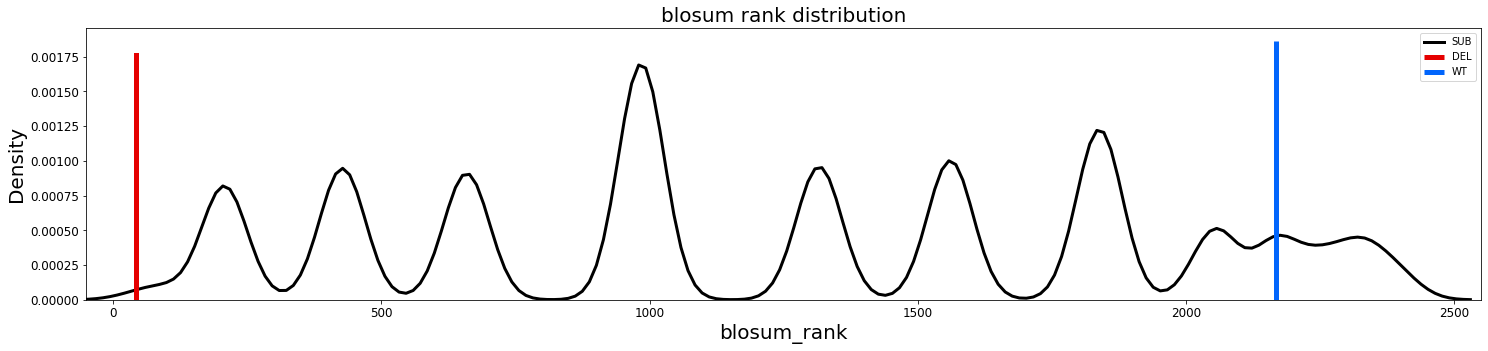

In [10]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='blosum', ax=ax, show_del=False)
plt.show()

BLOSUM public score = 0.196

# pLDDT

In [11]:
# Read AlphaFold2 result for wild type sequence:
plddt = (
    pd.read_csv('../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb', sep='\s+', header=None)[[0,5,10]]
    .rename(columns={0:'atom', 5:'resid', 10:'plddt'})
    .query('atom=="ATOM"')
    .drop_duplicates()
)

# Add B factor to the testing set:
test_df = pd.merge(
    test_df,
    plddt,
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df['plddt_rank'] = rankdata(-1*test_df['plddt'])

Notice how this method assigns a separate rank to each deletion:

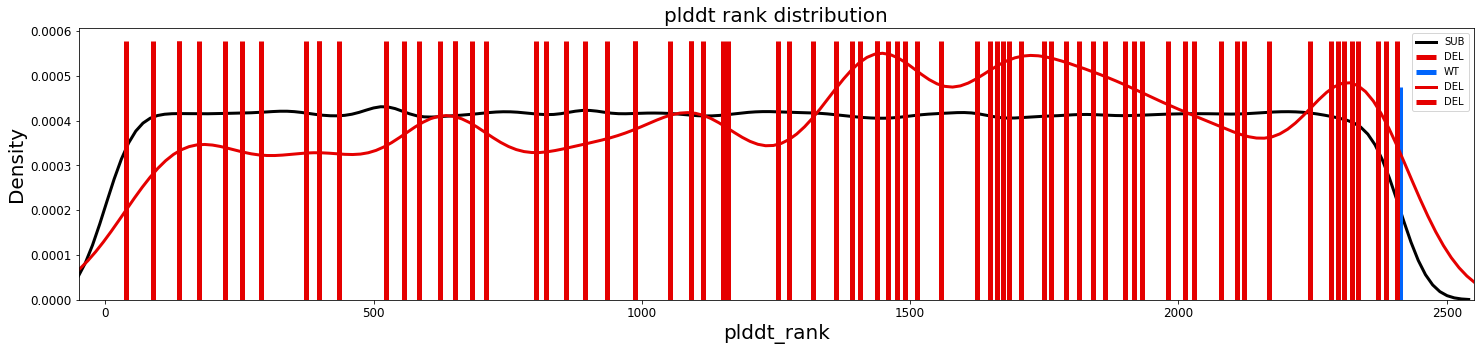

In [12]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddt', ax=ax, show_del=True)
plt.show()

pLDDT public score = 0.292

# Differential pLDDT

In [13]:
plddtdiff = []

# Wild type result:
wt_plddt = (
    pd.read_csv('../input/nesp-kvigly-test-mutation-pdbs/WT_unrelaxed_rank_1_model_3.pdb', sep='\s+')
    .loc['ATOM'].reset_index()
    .loc[:, ['level_4', 'MODEL']].drop_duplicates()
    .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
    .astype({'resid':int})
    .set_index('resid')
)

# Add difference in pLDDTto the testing set:>
for _,row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    file_path = '../input/nesp-kvigly-test-mutation-pdbs/{}{}{}_unrelaxed_rank_1_model_3.pdb'.format(row['wt'], row['resid'], row['mut'])
    if os.path.exists(file_path):
        tdf = (
            pd.read_csv(file_path, sep='\s+')
            .loc['ATOM'].reset_index()
            .loc[:, ['level_4', 'MODEL']].drop_duplicates()
            .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
            .astype({'resid':int})
            .set_index('resid')
        )
        plddtdiff.append((tdf.loc[row['resid']] - wt_plddt.loc[row['resid']]).values[0])
    else:
        plddtdiff.append(np.nan)

test_df['plddtdiff'] = plddtdiff
test_df['plddtdiff_rank'] = rankdata(test_df['plddtdiff'])

  0%|          | 0/2413 [00:00<?, ?it/s]

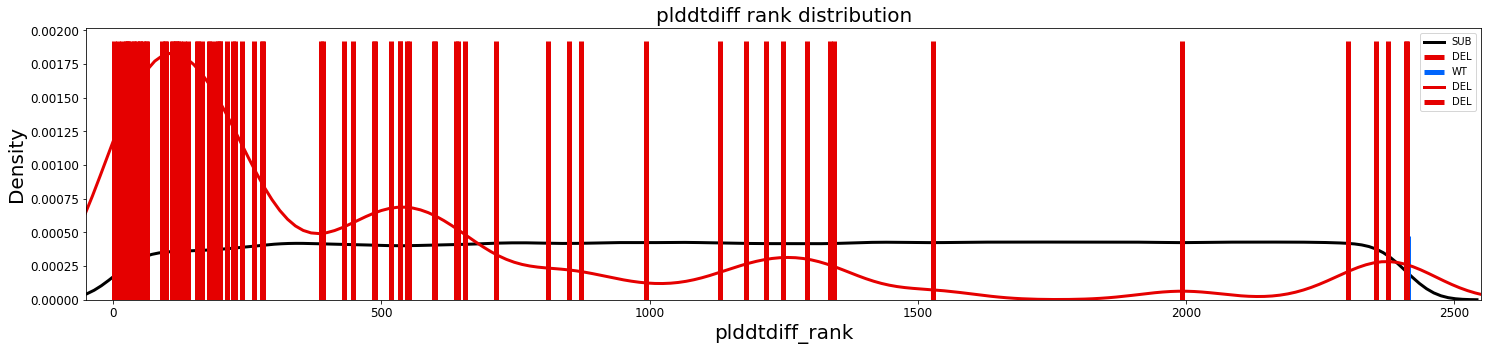

In [14]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddtdiff', ax=ax, show_del=True)
plt.show()

Differential pLDDT public score = 0.297

# DeMaSk

In [15]:
# Run DeMaSk on https://demask.princeton.edu/query/ by pasting the wild type sequence and clicking "Compute":
demask = pd.read_csv('../input/novozymes/demaskout.txt', sep='\t', usecols=[0,1,2,3], names=['resid','wt','mut','demask'], skiprows=1)

# Add DeMask output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    demask.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','demask'] = 0
test_df.loc[test_df['type']=='DEL','demask'] = test_df['demask'].dropna().min()


test_df['demask_rank'] = rankdata(test_df['demask'])

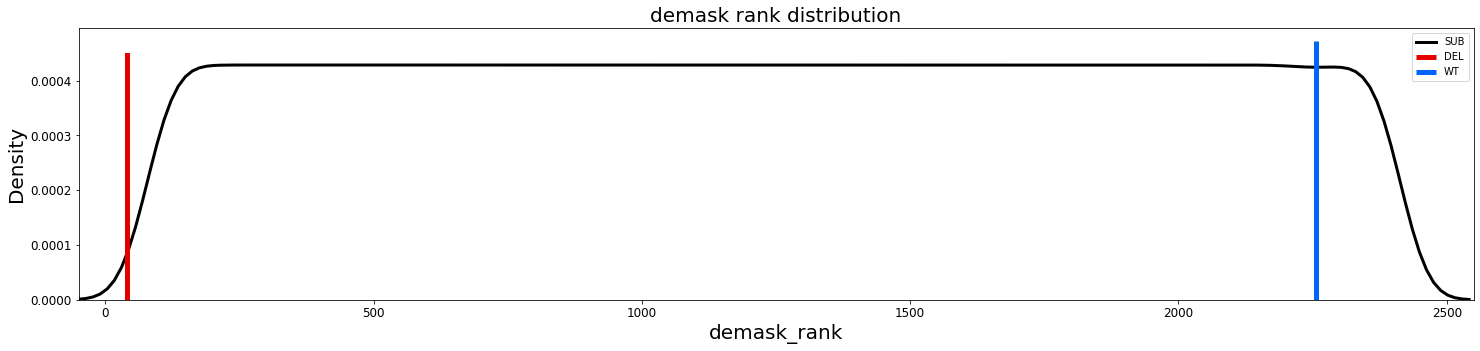

In [16]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='demask', ax=ax, show_del=False)
plt.show()

DeMaSk public score = 0.363

# RMSD

In [17]:
# Read VMD/NAMD output:
namd = pd.read_csv('../input/novozymes-md2/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','rmsd']],
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
# test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
# test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

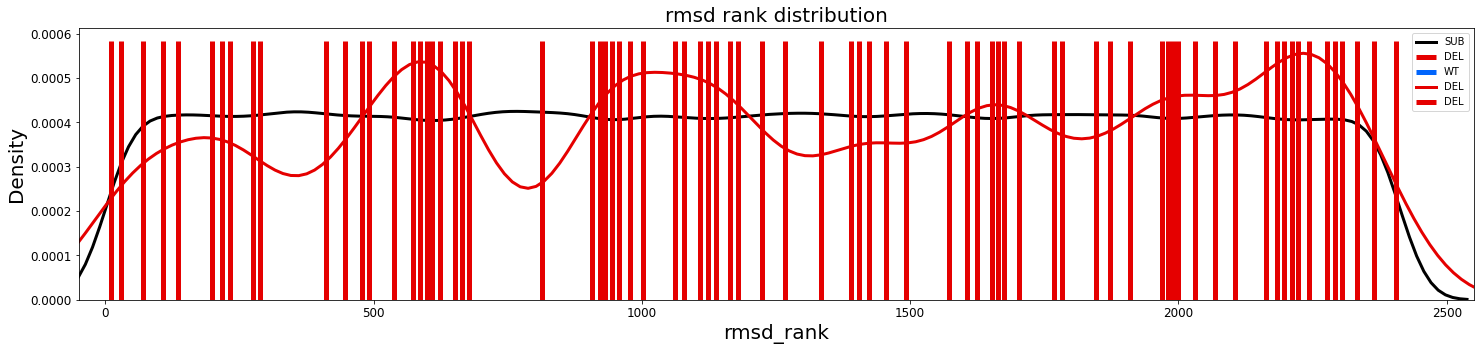

In [18]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rmsd', ax=ax, show_del=True)
plt.show()

RMSD public score = 0.393

# SASA

In [19]:
namd

,resid,rmsd,sasa0,sasaf
0,1,1.774145,198.432281,161.419312
1,2,1.656036,116.322868,115.720192
2,3,1.948815,134.644394,150.647171
3,4,2.296046,140.815231,91.828255
4,5,1.398716,119.585098,123.152199
...,...,...,...,...
216,217,0.885676,60.894875,72.163391
217,218,0.925841,97.304672,88.281517
218,219,0.615628,28.972021,41.354168
219,220,0.672172,21.619684,20.294685


In [20]:
# Read VMD/NAMD output:
namd = pd.read_csv('../input/novozymes-md/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','sasaf']],
    left_on='resid',
    right_on='resid',
    how='left'
)

# test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

# test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

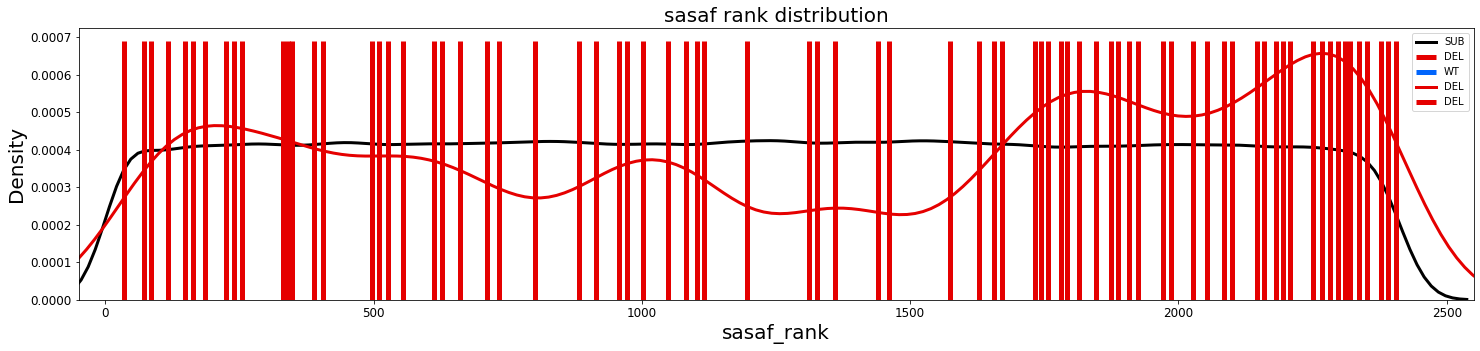

In [21]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='sasaf', ax=ax, show_del=True)
plt.show()

SASA public score = 0.408

# Rosetta

In [22]:
test_df['rosetta_rank'] = pd.read_csv('../input/nesp-relaxed-rosetta-scores/submission_rosetta_scores')['tm']
test_df['rosetta_rank'] = rank_nrom('rosetta')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','rosetta_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

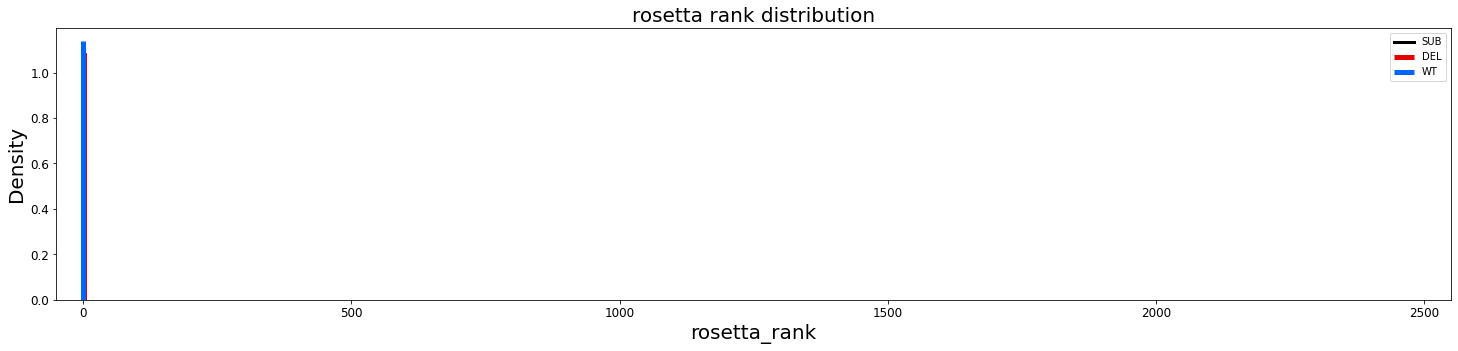

In [23]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rosetta', ax=ax, show_del=False)
plt.show()

Rosetta public score = 0.471

# Thermonet

In [24]:
test_df['thermonet'] = pd.read_csv('/kaggle/input/azer-subs/submission_seed_x6 (1).csv')['tm']
test_df['thermonet_rank'] = rankdata(test_df['thermonet'])
test_df['thermonet_rank'] = rank_nrom('thermonet')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','thermonet_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

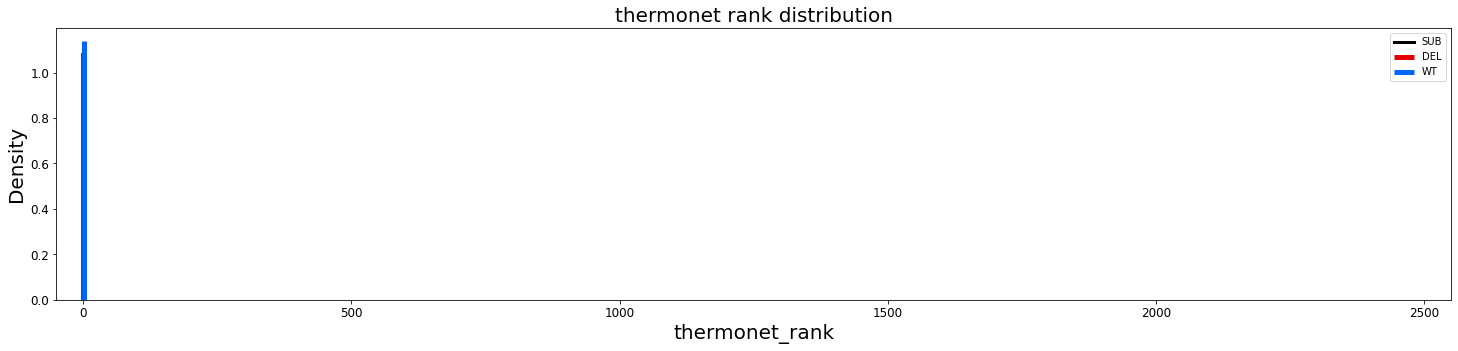

In [25]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='thermonet', ax=ax, show_del=False)
plt.show()

Thermonet public score = 0.494

# GEMME

In [26]:
test_df['gemme'] = pd.read_csv('/kaggle/input/gemme-sub/submission (22).csv')['tm']
test_df['gemme_rank'] = rankdata(test_df['gemme'])

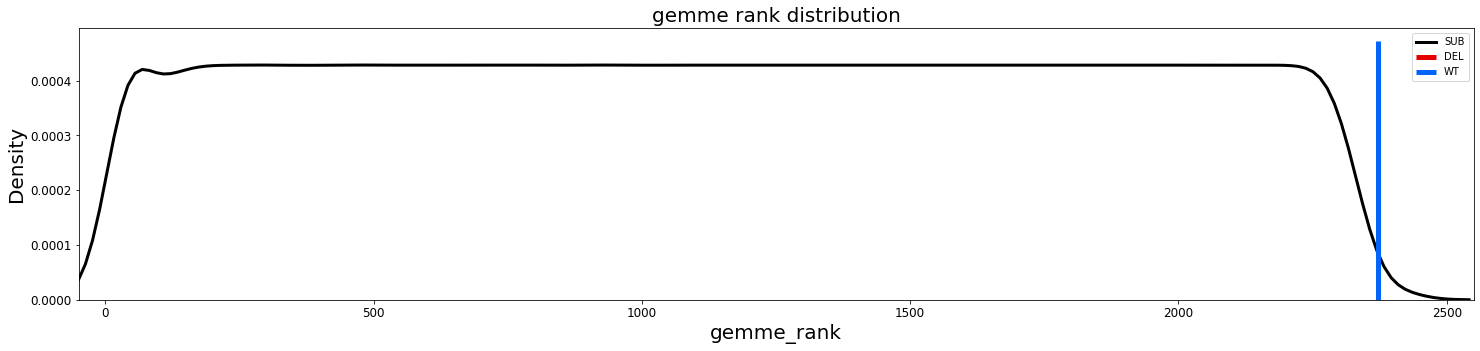

In [27]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='gemme', ax=ax, show_del=False)
plt.show()

# DeepDDG

In [28]:
# Run DeepDDG on http://protein.org.cn/ddg.html by uploading the PDB file and clicking "Submit":>
ddg = pd.read_csv('../input/novozymes/ddgout.txt', sep='\s+', usecols=[0,1,2,3,4]).rename(columns={'WT':'wt', 'ResID':'resid', 'Mut':'mut'})

# Add DeepDDG output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    ddg.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','ddG'] = 0
test_df.loc[test_df['type']=='DEL','ddG'] = test_df['ddG'].dropna().mean()


test_df['ddG_rank'] = rankdata(test_df['ddG'])
test_df['ddG_rank'] = rank_nrom('ddG')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','ddG_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

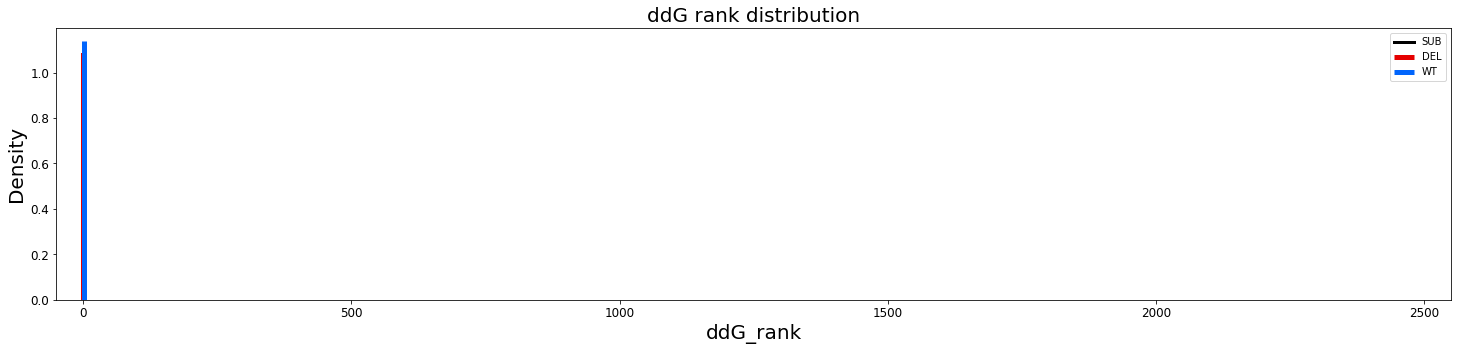

In [29]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='ddG', ax=ax, show_del=False)
plt.show()

# RASP

In [30]:
test_df['RASP'] = pd.read_csv('/kaggle/input/rasp-sub/sub.csv')['tm']
test_df['RASP_rank'] = rankdata(test_df['RASP'])
test_df['RASP_rank'] = rank_nrom('RASP')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','RASP_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

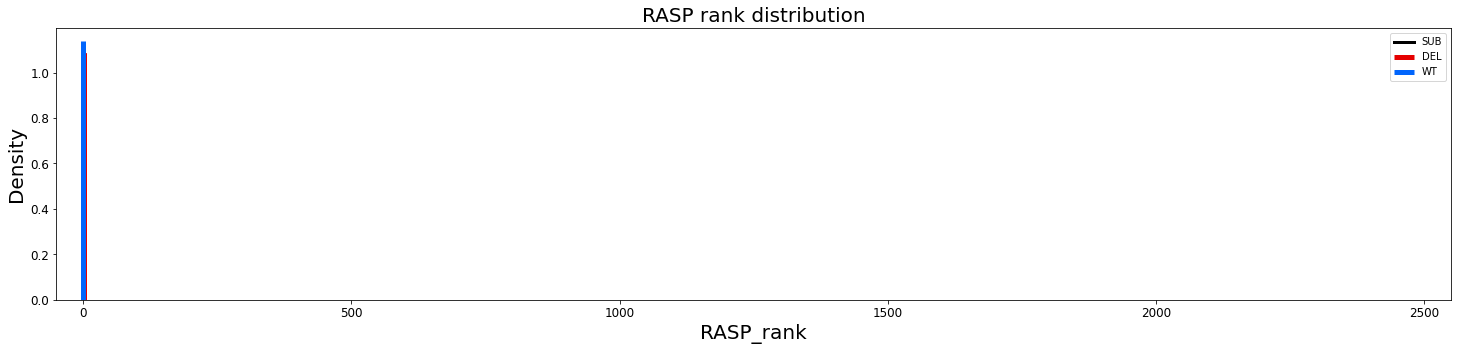

In [31]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='RASP', ax=ax, show_del=False)
plt.show()

# ProtBert

In [32]:
test_df['protbert'] = pd.read_csv('/kaggle/input/protbert/submission_bert_4 (1).csv')['tm']
test_df['protbert_rank'] = rankdata(test_df['protbert'])
# test_df['protbert_rank'] = rank_nrom('protbert')
# idx = test_df[test_df['type']=='DEL'].index
# test_df.loc[test_df['type']=='DEL','protbert_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

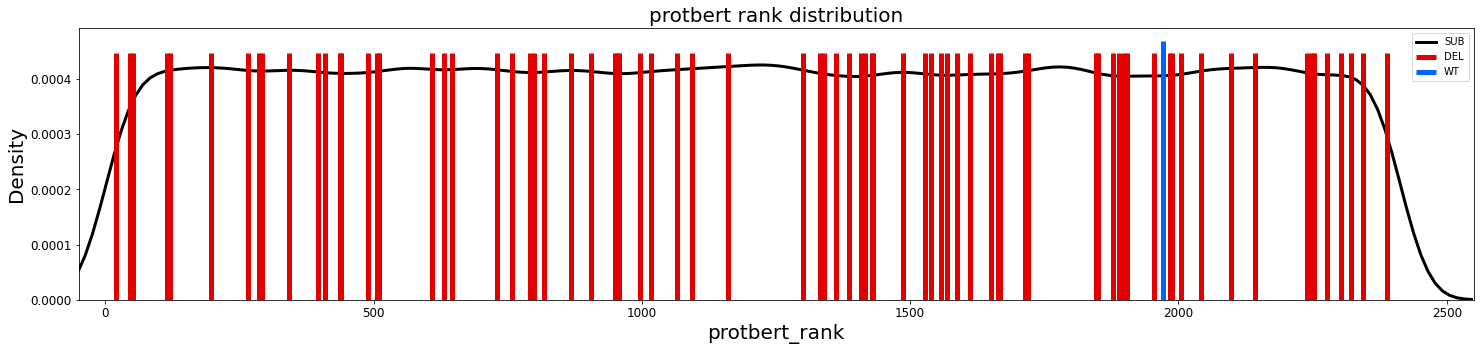

In [33]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='protbert', ax=ax, show_del=False)
plt.show()

# SAAFEC

In [34]:
saafec = pd.read_csv('/kaggle/input/azer-subs/saafec-seq.csv')
test_df['saafec'] = saafec['ddG'].copy()

test_df.loc[test_df['type']=='WT','saafec'] = 0
test_df.loc[test_df['type']=='DEL','saafec'] = test_df['saafec'].dropna().mean()

test_df['saafec_rank'] = rankdata(test_df['saafec'])
test_df['saafec_rank'] = rank_nrom('saafec')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','saafec_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

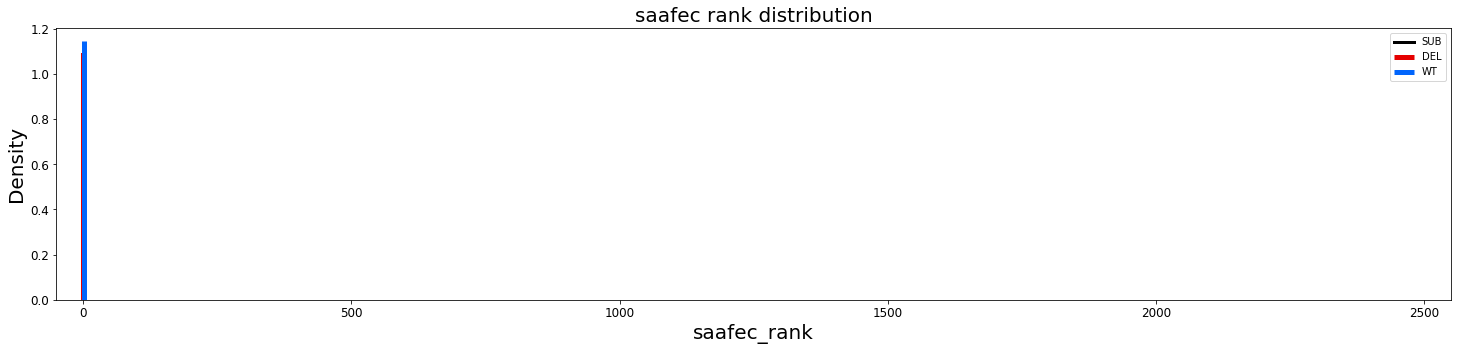

In [35]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='saafec', ax=ax, show_del=False)
plt.show()

# XGBoost

In [36]:
test_df['xgboost'] = pd.read_csv('/kaggle/input/azer-subs/submission_ver1_chris.csv')['tm']
test_df['xgboost_rank'] = rankdata(test_df['xgboost'])
test_df['xgboost_rank'] = rank_nrom('xgboost')
idx = test_df[test_df['type']=='DEL'].index
test_df.loc[test_df['type']=='DEL','xgboost_rank'] = (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

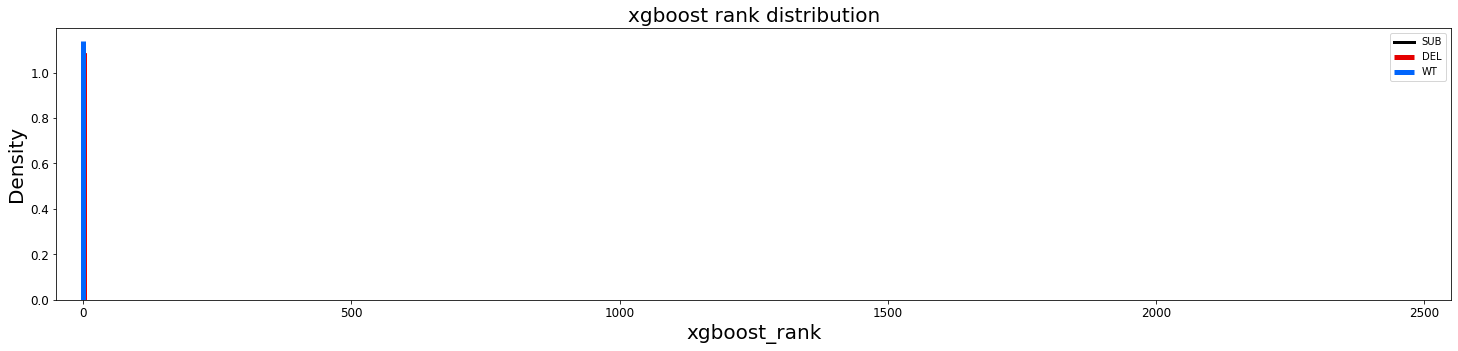

In [37]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='xgboost', ax=ax, show_del=False)
plt.show()

# Optuna

In [38]:
# from scipy.stats import pearsonr, spearmanr

# def subs_corr(new_sub):
#     sub = new_sub
#     best1 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3.csv') #0.612  -1st
#     best2 = pd.read_csv('/kaggle/input/azer-subs/Best61IhebProtBert_v1.csv') #0.611  -1st
#     best3 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0_ReplacingSASAandGEMME.csv') #0.610  0st
#     best4 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3AzerProtbert05ProtbertWeight.csv') #0.609  0st
#     best5 = pd.read_csv('/kaggle/input/azer-subs/Best612OptunaWeightsV4.csv') #0.607  1st
#     best6 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0.csv') #0.607  1st
#     best7 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3IhabThermonet60Seeds.csv') #0.607  2nd
#     best8 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v4 (1).csv') #0.607  2nd
#     best9 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v4.csv') #0.606  3rd
#     best10 = pd.read_csv('/kaggle/input/azer-subs/submission (46) (1).csv') #0.606  4th
#     best11 = pd.read_csv('/kaggle/input/azer-subs/submission (58).csv') #0.605  5th
#     best12 = pd.read_csv('/kaggle/input/azer-subs/submission (27) (1).csv') #0.604  6th
#     best13 = pd.read_csv('/kaggle/input/azer-subs/submission (43) (1).csv') #0.603  7th
#     best14 = pd.read_csv('/kaggle/input/azer-subs/submission (35) (1).csv') #0.601  8th
#     best15 = pd.read_csv('/kaggle/input/azer-subs/3blend.csv') #0.600  9th
#     best16 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3ReplacePlddtWith3DGeometry.csv') #0.591  9th
#     best17 = pd.read_csv('/kaggle/input/azer-subs/submission_ensemble.csv') #0.586  10th
#     best18 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0_modified.csv') #0.57  11th
#     best19 = pd.read_csv('/kaggle/input/azer-subs/submission (41) (1).csv') #0.569  12th
#     best20 = pd.read_csv('/kaggle/input/azer-subs/submission_seed_x6_log_trans_l1.csv') #0.495  13th

#     sub1 = sub.loc[:600]
#     sub2 = sub.loc[1800:]
#     current_sub = pd.concat([sub1,sub2])
    
#     corrs = []
#     for _sub in [best1,best2,best3,best4,best5,best6,best7,best8,best9,best10,best11,best12,best13,best14,best15,best16,best17,best18,best19,best20]:
#         sub1 = _sub.loc[:600]
#         sub2 = _sub.loc[1800:]
#         _sub = pd.concat([sub1,sub2])
#         corrs.append(pearsonr(current_sub['tm'],_sub['tm'])[0])
    
#     return -pearsonr(corrs,list(range(20)))[0], np.max(corrs)
    

    
# def CV(weights):
#     test_df['tm'] = weights['rosetta'] * test_df['rosetta_rank'] + weights['rmsd']*rank_nrom('rmsd') + weights['thermonet']*test_df['thermonet_rank'] + weights['plddtdiff']*rank_nrom('plddtdiff') + weights['saafec']*test_df['saafec'] + weights['xgboost']*test_df['xgboost'] +\
#                     weights['RASP']*test_df['RASP_rank'] + weights['plddt']*rank_nrom('plddt') + weights['demask']*rank_nrom('demask') + weights['ddG']*test_df['ddG_rank'] + weights['blosum']*rank_nrom('blosum') + weights['protbert']*rank_nrom('protbert')
                    
#     test_df['tm'] = test_df['tm']/test_df['tm'].max()
        
#     idx = test_df[test_df['type']=="DEL"].index
#     test_df.loc[idx, 'tm'] =  (weights['plddt_del']*rank_nrom('plddt')[idx] + weights['plddtdiff_del']*rank_nrom('plddtdiff')[idx] + weights['rmsd_del']*rank_nrom('rmsd')[idx] + weights['sasaf_del']*rank_nrom('sasaf')[idx]) / 6

#     # Wild type:
#     test_df.loc[test_df['type']=="WT",'tm'] = test_df['tm'].max()+1
#     test_df['tm'] = rankdata(test_df['tm'])
#     test_df['tm_rank'] = test_df['tm']
    
#     res, max_corr =  subs_corr(test_df[['seq_id','tm']].copy())
    
#     if (max_corr >= 0.97):
#         return 3*res 
#     elif (max_corr >= 0.93):
#         return 2*res
#     else:
#         return res

In [39]:
# import optuna
# def model_objective(trial):
#     _rosetta = trial.suggest_float("rosetta", 0, 1)
#     _rmsd = trial.suggest_float("rmsd",0, 1)
#     _thermonet = trial.suggest_float("thermonet", 0, 1)
#     _xgboost = trial.suggest_float("xgboost", -1, 1)
#     _plddtdiff = trial.suggest_float("plddtdiff", -0.3, 1)
#     _saafec = trial.suggest_float("saafec", -1, 1)
#     _RASP = trial.suggest_float("RASP", -0.5, 1)
# #     _sasaf = trial.suggest_float("sasaf", 0, 1)
#     _plddt = trial.suggest_float("plddt", -1, 1) 
#     _demask = trial.suggest_float("demask", -1, 0.2)
#     _ddG = trial.suggest_float("ddG", -1, 1)
#     _blosum = trial.suggest_float("blosum", -1, 0.5) 
# #     _gemme = trial.suggest_float("gemme", 0, 1)
#     _protbert = trial.suggest_float("protbert", -1, 0.3)
    
# #     _plddt_del = trial.suggest_float("plddt_del", 0, 1)
# #     _plddtdiff_del = trial.suggest_float("plddtdiff_del", 0, 1)
# #     _rmsd_del = trial.suggest_float("rmsd_del", 0, 1)
# #     _sasaf_del = trial.suggest_float("sasaf_del", 0, 1)

    
#     weights = {
#                'rosetta':_rosetta,
#                'rmsd': _rmsd,
#                'thermonet': _thermonet,
#                'plddtdiff': _plddtdiff,
#                'saafec': _saafec,
#                'RASP': _RASP,
# #                'sasaf': _sasaf,
#                'plddt': _plddt,
#                'demask': _demask,
#                'ddG': _ddG,
#                'blosum': _blosum,
# #                'gemme': _gemme,
#                'protbert': _protbert,
#                'xgboost': _xgboost,
#                'plddt_del': 2,
#                'plddtdiff_del': 2,
#                'rmsd_del': 1,
#                'sasaf_del': 1
#               }
    
#     #Use this CV after doing stratified sampling 
#     scores = CV(weights)
#     return scores
# #---------------------------------------------------------------
# def tune(objective):
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=10000)

#     params = study.best_params
#     best_score = study.best_value
#     print(f"Best score: {best_score}\n")
#     print(f"Optimized parameters: {params}\n")
#     return params


# LG_params = tune(model_objective)

# Ensembling

In [40]:
# Global Ensembling:
# weights = {'rosetta': 0.0003339756948327893, 'rmsd': 0.06052858520457104, 'thermonet': 0.11128042109765213, 'plddtdiff': 0.7253870028713355, 'RASP': 0.2018430829419693, 'plddt': 0.26998749676668454, 'demask': 0.036012645728232054, 'ddG': 0.0020925556079155467, 'blosum': 0.09073103461915846, 'protbert': 0.7473015899011571}
# weights = {'rosetta': 0.02772735771747253, 'rmsd': 0.07502041013819769, 'thermonet': 0.0011820327080543092, 'plddtdiff': 0.7064858320929904, 'RASP': 0.00017714731498520014, 'plddt': 0.07550851169201053, 'demask': 0.015836061663932692, 'ddG': 0.01758564820120013, 'blosum': 0.020474689783965654, 'protbert': 0.9371675321413412}
# weights = {'rosetta': 0.047133282007883893, 'rmsd': 0.11001875499008724, 'thermonet': 0.36873940044126946, 'plddtdiff': 0.9656320961468273, 'RASP': 0.8229036046559445, 'plddt': 0.749525096454869, 'demask': 0.0004165048707131518, 'ddG': 0.00024713443736654596, 'blosum': 0.3904426659849978, 'protbert': 0.7065572170348071}
# weights = {'rosetta': 0.3257114259750667, 'rmsd': 0.30440446928856696, 'thermonet': 0.9488159265152214, 'plddtdiff': 0.5943618221810497, 'RASP': 0.2197293434385342, 'plddt': 0.4313024546824956, 'demask': 0.08032228944728913, 'ddG': 0.11311130438366715, 'blosum': 0.27832488899220964, 'protbert': 0.2580243801578259}
# weights = {'rosetta': 1.2, 'rmsd': 0.999, 'thermonet': 0.999, 'plddtdiff': 0.7, 'RASP': 0.2, 'plddt': 0.3, 'demask': 0.08, 'ddG': 0.3, 'blosum': 0.3, 'protbert': 0.05}
# weights = {'rosetta': 1.2, 'rmsd': 0.9, 'thermonet': 0.6, 'plddtdiff': 0.7, 'saafec': 0.04, 'RASP': 0.3, 'plddt': 0.3, 'demask': -0.1, 'ddG': 0.3, 'blosum': 0.4, 'protbert': 0.2}
weights = {'rosetta': 0.23839888537408652, 'rmsd': 0.7330082519080582, 'thermonet': 0.938960989819195, 'xgboost': 0.07510881132234884, 'plddtdiff': 0.4854755902577429, 'saafec': 0.021316030749338508, 'RASP': 0.5419963714646772, 'plddt': 0.20758264604164886, 'demask': -0.3313645701895366, 'ddG': 0.33797022096225965, 'blosum': 0.34308504895991, 'protbert': 0.25415214752060483}
test_df['tm'] = weights['rosetta'] * test_df['rosetta_rank'] + weights['rmsd']*rank_nrom('rmsd') + weights['thermonet']*test_df['thermonet_rank'] + weights['plddtdiff']*rank_nrom('plddtdiff') + weights['saafec']*test_df['saafec'] +\
                    weights['RASP']*test_df['RASP_rank'] + weights['plddt']*rank_nrom('plddt') + weights['demask']*rank_nrom('demask') + weights['ddG']*test_df['ddG_rank'] + weights['blosum']*rank_nrom('blosum') + weights['protbert']*rank_nrom('protbert')

test_df['tm'] = test_df['tm']/test_df['tm'].max()

In [41]:
# # Scale ranks prior to ensembling:
# # Global ensemble:
# test_df['tm'] = (
#     4 * test_df['rosetta_rank'] + 2*rank_nrom('rmsd') + 2*test_df['thermonet_rank'] + 2*rank_nrom('plddtdiff') +\
#     test_df['RASP_rank'] + rank_nrom('plddt') + rank_nrom('demask') + 0.5*test_df['ddG_rank'] + rank_nrom('blosum') + 0.5*rank_nrom('protbert')
# ) / 16

# test_df['tm'] = test_df['tm']/test_df['tm'].max()

In [42]:
# Deletion type:
idx = test_df[test_df['type']=="DEL"].index
test_df.loc[idx, 'tm'] =  (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

# Wild type:
test_df.loc[test_df['type']=="WT",'tm'] = test_df['tm'].max()+1
test_df['tm'] = rankdata(test_df['tm'])
test_df['tm_rank'] = test_df['tm']

# Submission:
test_df[['seq_id','tm']].to_csv('Best612+OptunaNegativeWeights.csv', index=False)

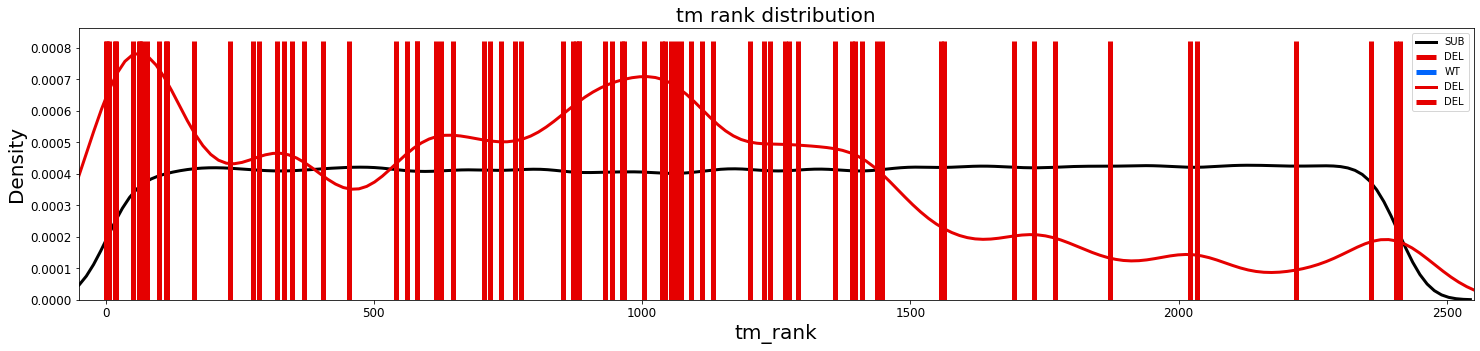

In [43]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='tm', ax=ax, show_del=True)
plt.show()

In [44]:
from scipy.stats import pearsonr, spearmanr
sub = test_df[['seq_id','tm']].copy()
# sub = pd.read_csv('/kaggle/input/azer-subs/saafec_postprocess.csv')
best1 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3.csv') #0.612  -1st
best2 = pd.read_csv('/kaggle/input/azer-subs/Best61IhebProtBert_v1.csv') #0.611  -1st
best3 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0_ReplacingSASAandGEMME.csv') #0.610  0st
best4 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3AzerProtbert05ProtbertWeight.csv') #0.609  0st
best5 = pd.read_csv('/kaggle/input/azer-subs/Best612OptunaWeightsV4.csv') #0.607  1st
best6 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0.csv') #0.607  1st
best7 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3IhabThermonet60Seeds.csv') #0.607  2nd
best8 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v4 (1).csv') #0.607  2nd
best9 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v4.csv') #0.606  3rd
best10 = pd.read_csv('/kaggle/input/azer-subs/submission (46) (1).csv') #0.606  4th
best11 = pd.read_csv('/kaggle/input/azer-subs/submission (58).csv') #0.605  5th
best12 = pd.read_csv('/kaggle/input/azer-subs/submission (27) (1).csv') #0.604  6th
best13 = pd.read_csv('/kaggle/input/azer-subs/submission (43) (1).csv') #0.603  7th
best14 = pd.read_csv('/kaggle/input/azer-subs/submission (35) (1).csv') #0.601  8th
best15 = pd.read_csv('/kaggle/input/azer-subs/3blend.csv') #0.600  9th
best16 = pd.read_csv('/kaggle/input/azer-subs/Best610OptunaWeightsV3ReplacePlddtWith3DGeometry.csv') #0.591  9th
best17 = pd.read_csv('/kaggle/input/azer-subs/submission_ensemble.csv') #0.586  10th
best18 = pd.read_csv('/kaggle/input/azer-subs/submission_az_blend_v0_modified.csv') #0.57  11th
best19 = pd.read_csv('/kaggle/input/azer-subs/submission (41) (1).csv') #0.569  12th
best20 = pd.read_csv('/kaggle/input/azer-subs/submission_seed_x6_log_trans_l1.csv') #0.495  13th

sub1 = sub.loc[:600]
sub2 = sub.loc[1800:]
current_sub = pd.concat([sub1,sub2])

for _sub in [best1,best2,best3,best4,best5,best6,best7,best8,best9,best10,best11,best12,best13,best14,best15,best16,best17,best18,best19,best20]:
    sub1 = _sub.loc[:600]
    sub2 = _sub.loc[1800:]
    _sub = pd.concat([sub1,sub2])
    print(pearsonr(current_sub['tm'],_sub['tm'])[0])
    
# 0.9912567451309267
# 0.990116559653541
# 0.9880502292220489
# 0.9880254615669057
# 0.9851477083937878
# 0.9834346178262973
# 0.9840559872049157
# 0.9695589627052998
# 0.9763028009041198
# 0.9383385353627847
# 0.9695470797019035
# 0.9597494713944587
# 0.9154525097223675
# 0.7175130016044065

0.9667987715060714
0.9663564861994235
0.9473735445917463
0.9702387537911991
0.9569482810551491
0.9375359199966607
0.9669165517103375
0.9338185302109332
0.9337184152885525
0.932505628359631
0.9309258314185479
0.9503962260432064
0.9161447442810122
0.9244274999082399
0.8818699034599901
0.9508587699174785
0.8996283724105752
0.8979776843276163
0.809700678588667
0.7737915349770057


Thank you for reading!

---

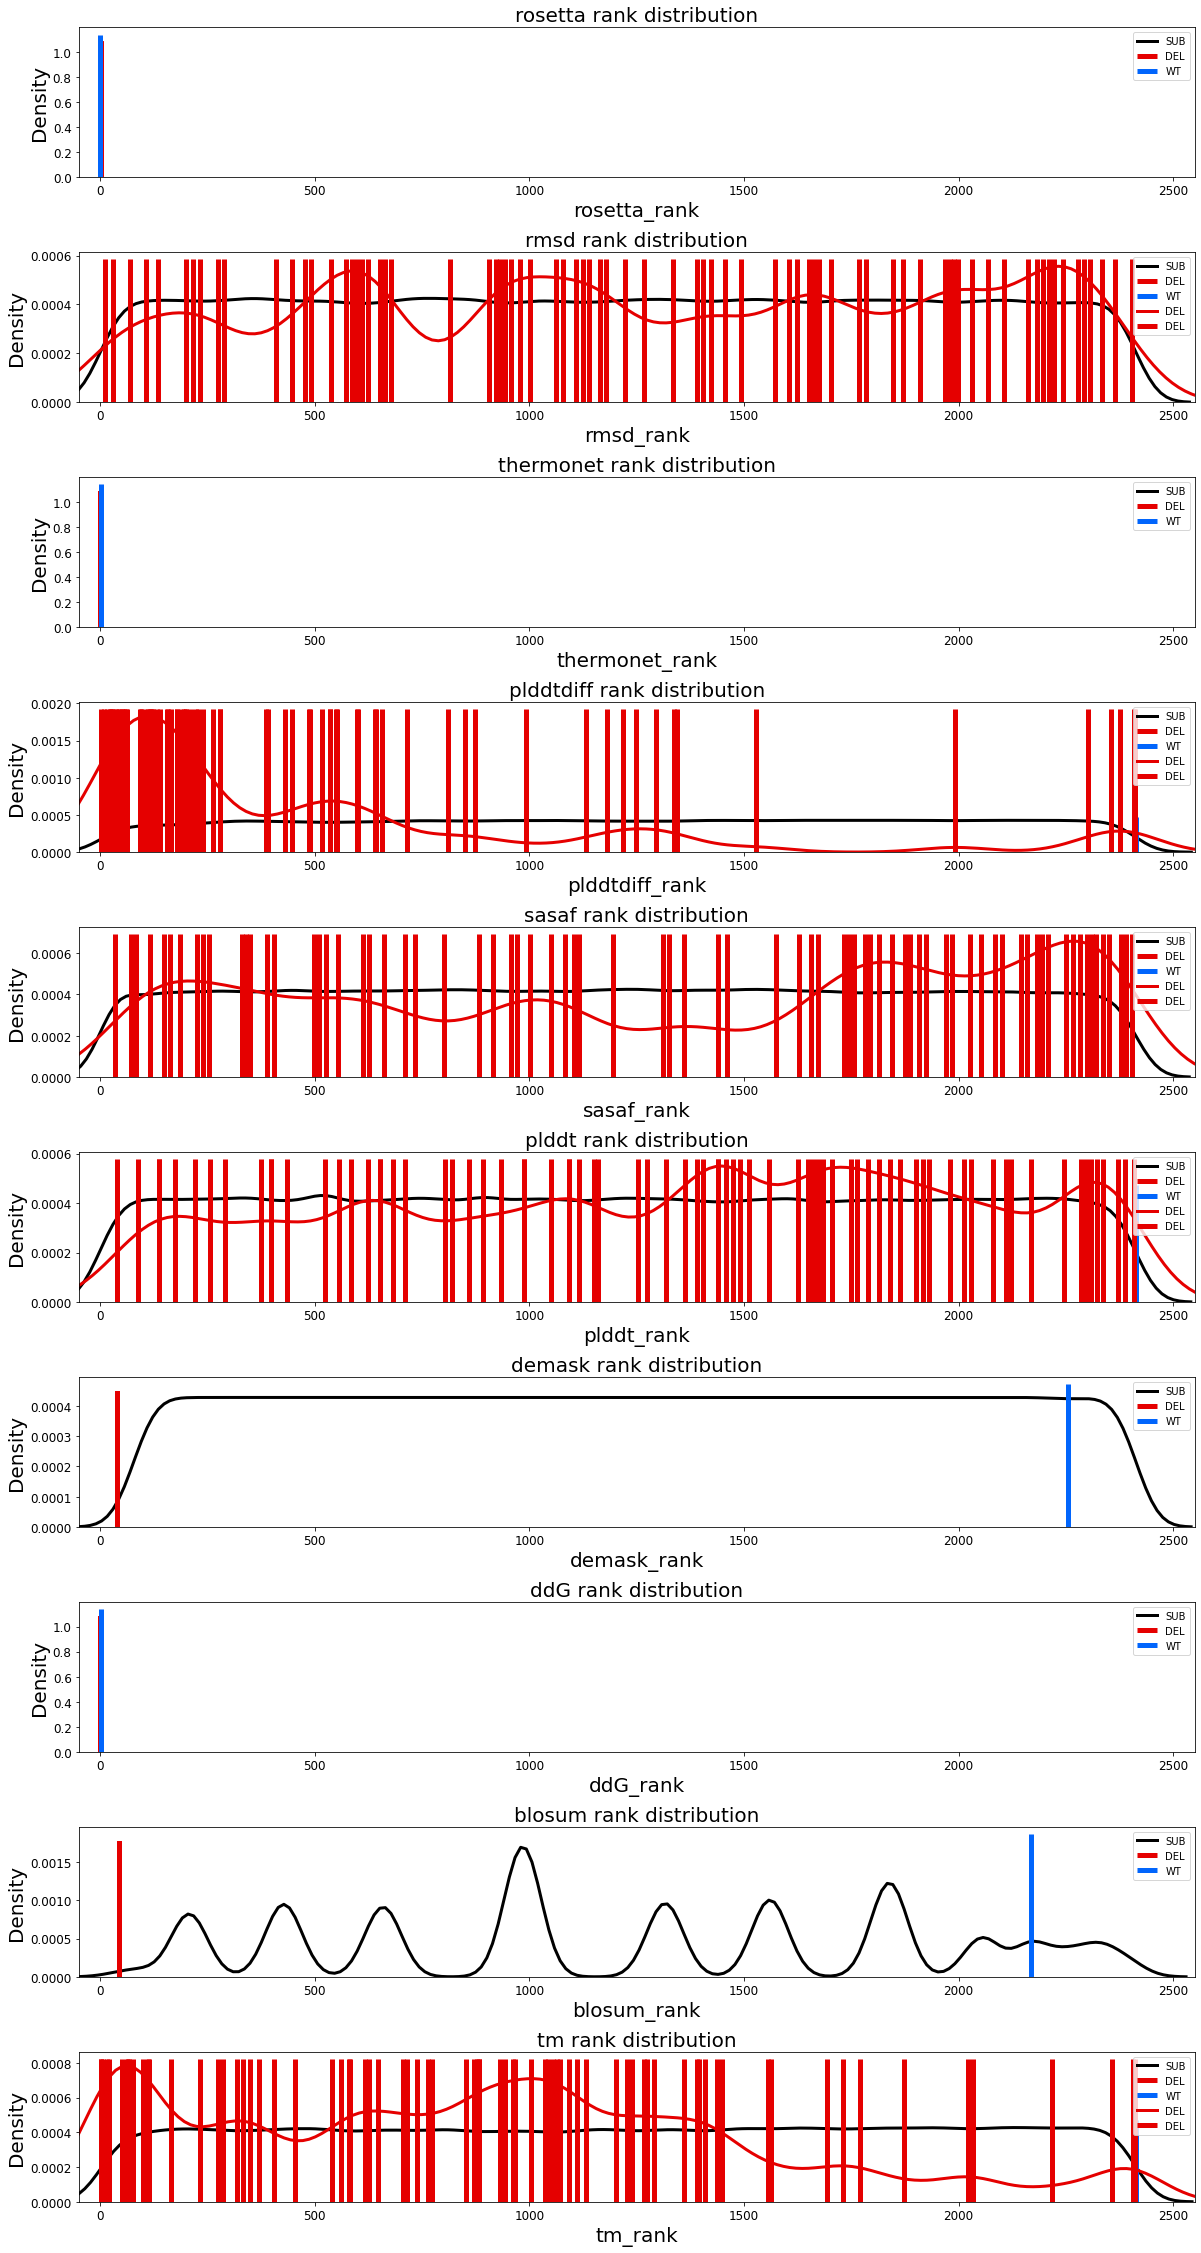

In [45]:
fig, axs = plt.subplots(nrows=10, figsize=(20,40), gridspec_kw={'hspace':0.5})


plot_rank_dist(name='rosetta', ax=axs[0], show_del=False)
plot_rank_dist(name='rmsd', ax=axs[1], show_del=True)
plot_rank_dist(name='thermonet', ax=axs[2], show_del=False)
plot_rank_dist(name='plddtdiff', ax=axs[3], show_del=True)
plot_rank_dist(name='sasaf', ax=axs[4], show_del=True)
plot_rank_dist(name='plddt', ax=axs[5], show_del=True)
plot_rank_dist(name='demask', ax=axs[6], show_del=False)
plot_rank_dist(name='ddG', ax=axs[7], show_del=False)
plot_rank_dist(name='blosum', ax=axs[8], show_del=False)

plot_rank_dist(name='tm', ax=axs[9], show_del=True)

plt.show()